<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Todo:
- Update text
- Use proof-read version of the IC/00 notebook


# WebCam Image Classification Quickstart Notebook

<br>

Image classification is a classical problem in computer vision that of determining whether or not the image data contains some specific object, feature, or activity. It is regarded as a mature research area
and currently the best models are based on [convolutional neural networks (CNNs)](https://en.wikipedia.org/wiki/Convolutional_neural_network). Such models with weights trained on millions of images and hundreds of object classes in [ImageNet dataset](http://www.image-net.org/) are available from major deep neural network frameworks such as [CNTK](https://www.microsoft.com/en-us/cognitive-toolkit/features/model-gallery/), [fast.ai](https://docs.fast.ai/vision.models.html#Computer-Vision-models-zoo), [Keras](https://keras.io/applications/), [PyTorch](https://pytorch.org/docs/stable/torchvision/models.html), and [TensorFlow](https://tfhub.dev/s?module-type=image-classification).


This notebook shows a simple example of how to load pretrained model and run it on a webcam stream. Here, we use [ResNet](https://arxiv.org/abs/1512.03385) model by utilizing `fastai.vision` package.

> For more details about image classification tasks including transfer-learning (aka fine tuning), please see our [training introduction notebook](01_training_introduction.ipynb).

### Prerequisite for Webcam example 
You will need to run this notebook on **a machine with a webcam**. We use `ipywebrtc` module to show the webcam widget<sup>*</sup> on the notebook. Currently, the widgets work on **Chrome** and **Firefox**. For more details about the widget, please visit `ipywebrtc` [github](https://github.com/maartenbreddels/ipywebrtc) or [doc](https://ipywebrtc.readthedocs.io/en/latest/).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("../")
sys.path.append("../..")
import io
import os
import time
import urllib.request

import fastai
from fastai.vision import models, open_image, load_learner, ImageList, cnn_learner
from ipywebrtc import CameraStream, ImageRecorder
from ipywidgets import HBox, Label, Layout, Widget

from utils_cv.common.data import data_path, get_files_in_directory, unzip_url
from utils_cv.common.gpu import which_processor
from utils_cv.classification.data import imagenet_labels, Urls
from utils_cv.classification.model import IMAGENET_IM_SIZE, model_to_learner

import utils_is
from utils_is.metrics import compute_topk_similar
from utils_is.utils import plot_similars, SaveFeatures

print(f"Fast.ai: {fastai.__version__}")
#which_processor()

Fast.ai: 1.0.48


## 1. Load Pretrained Model

We use pretrained<sup>*</sup> ResNet18 which is a relatively small and fast among the well-known CNNs architectures. The [reported error rate](https://pytorch.org/docs/stable/torchvision/models.html) of the model on ImageNet is 30.24% for top-1 and 10.92% for top-5 (top five labels considered most probable by the model).

The model expects input RGB-images to be loaded into a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225], which is defined in [`fastai.vision.imagenet_stats`](https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L78).

The output of the model is the probability distribution of the classes in ImageNet. To convert them into human-readable labels, we utilize the label json file used from [Keras](https://github.com/keras-team/keras/blob/master/keras/applications/imagenet_utils.py).

> \* The model is pretrained on ImageNet. Note you can load your own model by using `learn = load_learner(path)` and use it. To learn more about model-export and load, see fastai [doc](https://docs.fast.ai/basic_train.html#Deploying-your-model)).


Note, Fastai's **[Learner](https://docs.fast.ai/basic_train.html#Learner)** is the trainer for model using data to minimize loss function with optimizer. We follow Fastai's naming convention, *'learn'*, for a `Learner` object variable.

## 2. Image retrieval

### 2.1 Load images and model
First, we load the query and the reference images

In [3]:
BATCH_SIZE = 2
IMAGE_SIZE = 30

im_path = unzip_url(Urls.fridge_objects_path, exist_ok=True) #"C:/Users/pabuehle/Desktop/ComputerVisionBestPractices/data/fridgeObjects/can/1.jpg"
ref_im_path = os.path.join(im_path,"can")
query_im_path = os.path.join(im_path,"can/1.jpg")
print(f"query_im_path = {query_im_path}")
print(f"ref_im_path = {ref_im_path}")

# Construct a DataBunch 
ref_data = (ImageList.from_folder(ref_im_path)
        .split_none()
        .label_from_folder()
        .transform(tfms=None,size=IMAGE_SIZE)
        .databunch(bs=BATCH_SIZE))
#print(ref_data.train_ds)
print(type(ref_data))

query_im_path = C:\Users\pabuehle\Desktop\ComputerVision\data\fridgeObjects\can/1.jpg
ref_im_path = C:\Users\pabuehle\Desktop\ComputerVision\data\fridgeObjects\can
<class 'fastai.vision.data.ImageDataBunch'>


Next we load the model

In [4]:
# Convert a pretrained imagenet model into Learner for prediction. 
# You can load an exported model by learn = load_learner(path) as well.
#learn = model_to_learner(models.resnet18(pretrained=True), 30)
#learn = load_learner("C:/Users/pabuehle/Desktop/ComputerVision/similarity/notebooks/")

# STRANGELY model_to_learner() LEADS TO AN ERROR FURTHER BELOW. FOR NOW, USE THIS LINE.
learn = cnn_learner(ref_data, models.resnet18, pretrained=True)

### 2.2 Featurization of reference images
In this section we compute (or load from disk if already pre-computed) the DNN embeddings for all reference images. 




In [5]:
# Compute DNN embeddings for the reference set
target_layer = learn.model[1][6]
featurizer = SaveFeatures(target_layer) 
learn.get_preds(ref_data.train_ds)
ref_features = featurizer.features
print(ref_features.shape)

ref_im_paths = [str(x) for x in list(ref_data.train_ds.items)]
ref_feature_dict = dict(zip(ref_im_paths, ref_features))

(32, 512)


### 2.3 Image retrieval from file
First, we load a *query* image from file and compare it to a *reference* dataset.

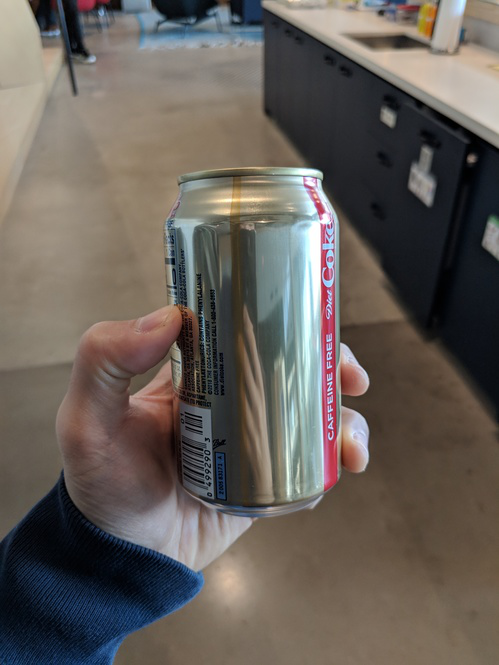

In [6]:
query_im = open_image(query_im_path, convert_mode='RGB')
query_im

In [7]:
start_time = time.time()

# Use the model to predict the class label
featurizer.features = None
_ = learn.predict(query_im)
query_features = featurizer.features

# Show prediction time. Note the first prediction usually takes longer because of the model loading
print(f"Took {time.time()-start_time} sec")

print(query_features.shape)
print(ref_features.shape)

Took 0.0549314022064209 sec
(1, 512)
(32, 512)


[('C:\\Users\\pabuehle\\Desktop\\ComputerVision\\data\\fridgeObjects\\can\\1.jpg', 9.934984e-07), ('C:\\Users\\pabuehle\\Desktop\\ComputerVision\\data\\fridgeObjects\\can\\26.jpg', 2.7763758), ('C:\\Users\\pabuehle\\Desktop\\ComputerVision\\data\\fridgeObjects\\can\\14.jpg', 2.787845)]


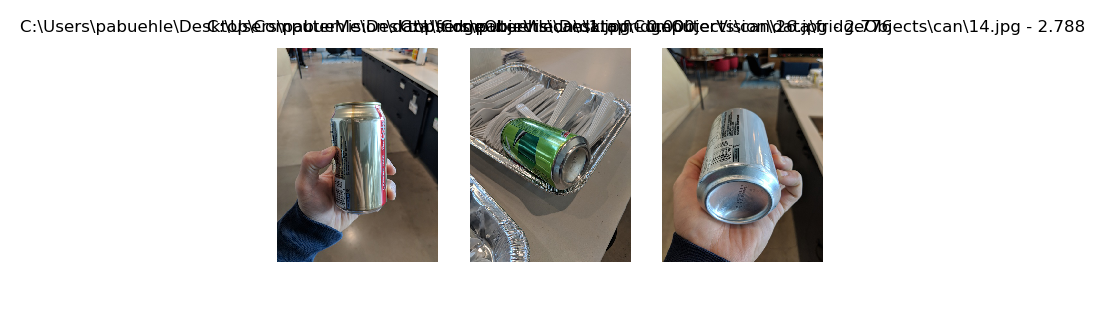

In [8]:
DISTANCE = "l2"
TOP_K = 3

# THIS FUNCTION NEEDS TO BE REFACTORED
similars = compute_topk_similar(query_features, ref_feature_dict, distance=DISTANCE, top_k=TOP_K) #, query_features = query_features)
print(similars)
plot_similars(similars)

### 2.4 Image retrieval from webcam footage

Now, let's use WebCam stream for image retrieval. We use `ipywebrtc` to start a webcam and get the video stream to the notebook's widget.

In [9]:
from ipywidgets import widgets

# Webcam
w_cam = CameraStream(
    constraints={
        'facing_mode': 'user',
        'audio': False,
        'video': { 'width': IMAGE_SIZE, 'height': IMAGE_SIZE }
    },
    layout=Layout(width=f'{IMAGE_SIZE}px')
)
# Image recorder for taking a snapshot
w_imrecorder = ImageRecorder(stream=w_cam, layout=Layout(padding='0 0 0 50px'))
# Label widget to show our classification results
#w_label = Label(layout=Layout(padding='0 0 0 50px'))
w_img = widgets.Image()

def classify_frame(_):
    """ Classify an image snapshot by using a pretrained model
    """
    # Once capturing started, remove the capture widget since we don't need it anymore
    if w_imrecorder.layout.display != 'none':
        w_imrecorder.layout.display = 'none'
        
    try:
        im = open_image(io.BytesIO(w_imrecorder.image.value), convert_mode='RGB')
        featurizer.features = None
        _, ind, prob = learn.predict(query_im)
        query_features = featurizer.features
        
        similars = compute_topk_similar(query_features, ref_feature_dict, distance=DISTANCE, top_k=1, query_features = query_features)
        im_path, distance = similars[0][1]
        
        #_, ind, prob = learn.predict(im)
        # Show result label and confidence
        #w_label.value = str(prob[ind])
        w_img.value = open(im_path, "rb").read()
    except OSError:
        # If im_recorder doesn't have valid image data, skip it. 
        pass
    
    # Taking the next snapshot programmatically
    w_imrecorder.recording = True

# Register classify_frame as a callback. Will be called whenever image.value changes. 
w_imrecorder.image.observe(classify_frame, 'value')

In [10]:
# Show widgets
HBox([w_cam, w_imrecorder, w_img])

Now, click the **capture button** of the image recorder widget to start classification. Labels show the most probable class along with the confidence predicted by the model for an image snapshot.

<img src="https://cvbp.blob.core.windows.net/public/images/cvbp_webcam.png" width="400" />
<center>
<i>Webcam image classification example</i>
</center>

In this notebook, we have shown a quickstart example of using a pretrained model to classify images. The model, however, is not able to predict the object labels that are not part of ImageNet. From our [training introduction notebook](01_training_introduction.ipynb), you can find how to fine-tune the model to address such problems.

In [11]:
# Stop the model and webcam
#Widget.close_all()